# Total Return CAPE Ratio

### Prof. Shiller addressed the criticism of traditional CAPE ratio, that changes in corporate payout policy, such as share repurchases instead of dividends as dominant approach in the USA for cash distribution to shareholders, which can affect the growth rate and the average of the real earnings per share used in the CAPE ratio, by develping a Total Return CAPE, which corrects this bias by reinvesting dividents into the price index and properly scaling earnings per share.

### Total Return EPS tells us what earnings would have been if the dividend payout ratio had been 0% at all times. This way, it reduces all earnings data across all periods of history to the same common basis, allowing for accurate comparisons between any two points in time.

 ### Total Return CAPE is used as a valuation metric to forecast future returns, where a higher CAPE ratio could reflect lower returns over the next couple of decades, whereas a lower CAPE ratio could reflect higher returns over the next couple of decades, as the ratio reverts back to the mean.

Source:

[Online Data Robert Shiller](http://www.econ.yale.edu/~shiller/data.htm)
 
[A New-and-Improved Shiller CAPE: Solving the Dividend Payout Ratio Problem](http://www.philosophicaleconomics.com/2015/03/payout/)

In [24]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Created date range because of the date formating in the excel file - easier -  (Oct month was showing as Jan after reading it in as string)
start_date = '1881-01-01'
end_date = '2022-12-01'
dates = pd.date_range(start_date, end_date,freq='M')

In [35]:
# Read in TR_CAPE and S&P 500 data from Online Data Robert Shiller, drop nans, convert Date to str, edit Date column, 
# Convert to datetime, set date as index, edit column names, use data from 1970-2020
tr_cape = pd.read_excel('resources/TR_CAPE.xlsx').dropna()
tr_cape = tr_cape.drop(columns='Date')
tr_cape['Date'] = dates
tr_cape['Date'] = pd.to_datetime(tr_cape['Date']).dt.strftime('%Y-%m')
tr_cape = tr_cape.rename(columns= {'P':'S&P500', 'TR CAPE':'TR_CAPE', 'Excess CAPE Yield':'ECY(%)'})
tr_cape = tr_cape.set_index('Date')
tr_cape['ECY(%)'] = tr_cape['ECY(%)']*100
tr_cape = tr_cape.loc['1957':]
tr_cape

,S&P500,TR_CAPE,ECY(%)
Date,,,
1957-01,45.430000,20.863186,5.050736
1957-02,43.470000,19.762632,5.537812
1957-03,44.030000,19.821837,5.293318
1957-04,45.050000,20.086831,5.173003
1957-05,46.780000,20.661107,4.912398
...,...,...,...
2022-07,3831.390000,31.457727,3.152220
2022-08,4158.563043,33.279933,2.901569
2022-09,3850.520476,30.592063,2.543230


In [36]:
# Calculate TR CAPE stats
stats = tr_cape['TR_CAPE'].describe()
stats

count    791.000000
mean      23.634681
std        8.329562
min        8.400297
25%       18.137256
50%       23.493817
75%       28.260063
max       48.110969
Name: TR_CAPE, dtype: float64

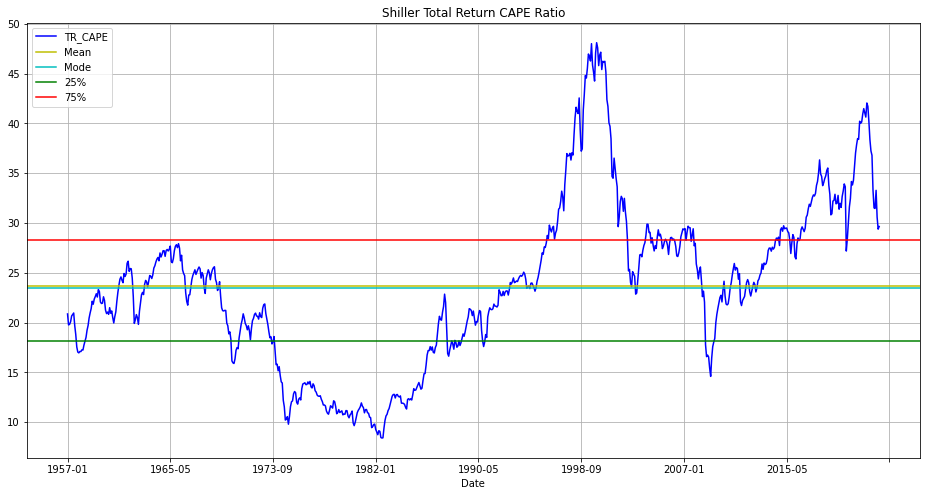

In [37]:
# Plot TR CAPE mean, mode, 25% and 75% values over selected time frame
tr_cape['TR_CAPE'].plot(figsize=(16,8), title='Shiller Total Return CAPE Ratio', legend=True, c='b', grid=True)
plt.axhline(stats['mean'], c='y', label='Mean')
plt.axhline(stats['50%'], label='Mode', c='c')
plt.axhline(stats['25%'], label='25%', c='g')
plt.axhline(stats['75%'], label='75%', c='r')
plt.legend()

# ECY - Excess CAPE Yield 
### ECY is calculated by the inverse of Shiller PE, which is the Shiller earnings yield, subtracted by the U.S. 10-year Treasury bond yield. Higher ECY values indicate higher equity premium over bonds which makes stocks more attractive.
#### [Source: Equity market valuation in light of low interest rates - Ana Maria Ceh Jonatan Manfredini Ola Melander Stephan Wollert](https://www.riksbank.se/globalassets/media/rapporter/staff-memo/engelska/2021/equity-market-valuation-in-light-of-low-interest-rates.pdf)

In [38]:
stats_ecy = tr_cape['ECY(%)'].describe()
stats_ecy 

count    791.000000
mean       3.528631
std        2.423432
min       -1.521674
25%        1.743992
50%        2.963453
75%        5.024058
max       10.801409
Name: ECY(%), dtype: float64

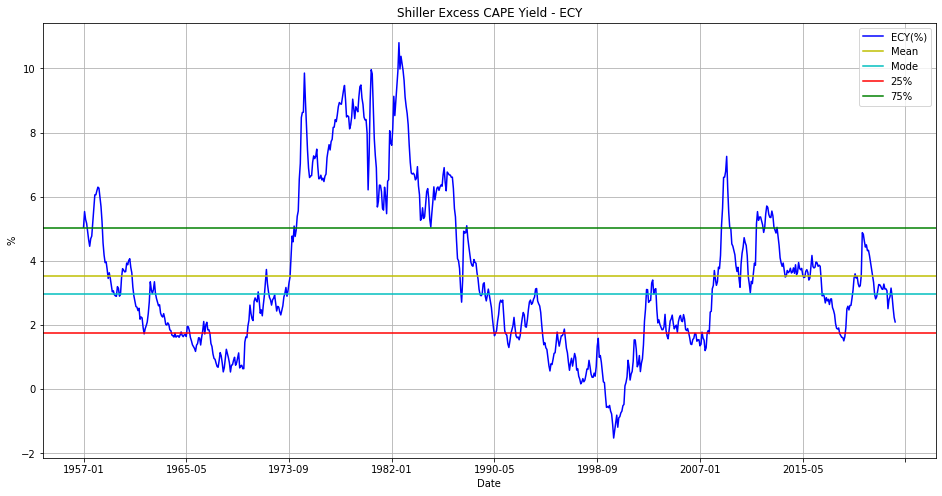

In [39]:
# Read in ECY and S&P 500 data from Online Data Robert Shiller, drop nans, convert Date to str, edit Date column, 
# Convert to datetime, set date as index, edit column names, use data from 1970-2020
# Plot ECY mean, mode, 25% and 75% values over selected time frame
tr_cape['ECY(%)'].plot(figsize=(16,8), title='Shiller Excess CAPE Yield - ECY', legend=True, c='b', grid=True)
plt.axhline(stats_ecy['mean'], c='y', label='Mean')
plt.axhline(stats_ecy['50%'], label='Mode', c='c')
plt.axhline(stats_ecy['25%'], label='25%', c='r')
plt.axhline(stats_ecy['75%'], label='75%', c='g')
plt.ylabel('%')
plt.legend()

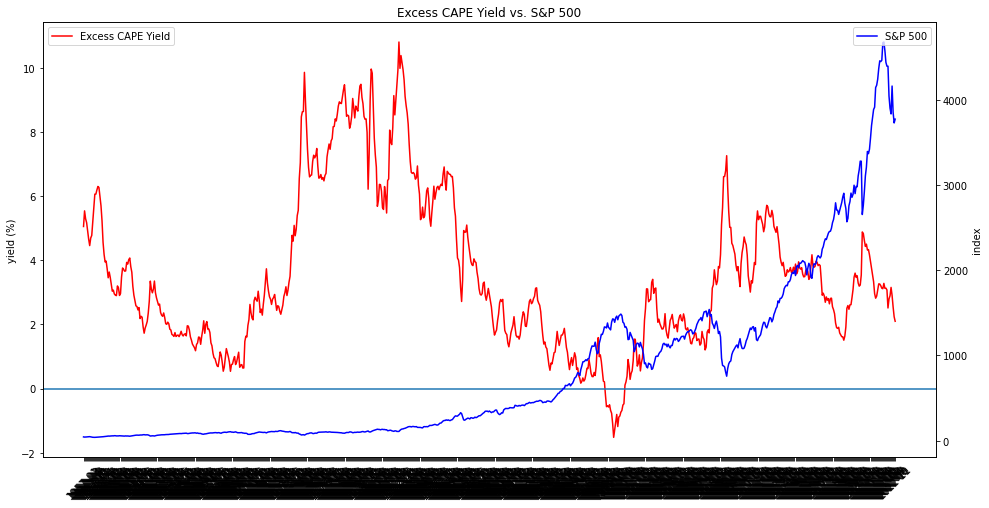

In [41]:
# Plot ECY vs S&P 500 
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(tr_cape['ECY(%)'], label ='Excess CAPE Yield', color='r')
ax.set_ylabel('yield (%)')
ax.axhline(y=0)
ax.legend(loc='upper left')
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()
plt.plot(tr_cape['S&P500'], label='S&P 500', color='b')
ax.set_title('Excess CAPE Yield vs. S&P 500')
ax2.set_ylabel('index')
ax2.legend(loc='upper right')